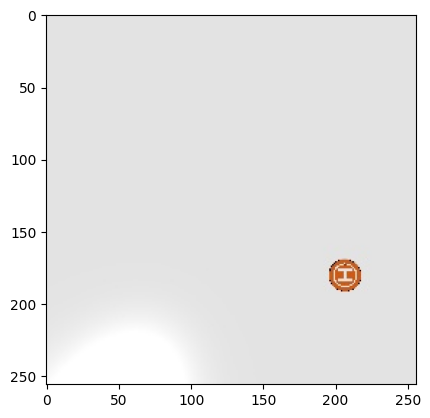

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img_land1 = Image.open('Dataset/landzone/1.jpg')

plt.imshow(img_land1)